In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set API keys from environment
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY", "")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING", "true")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT", "https://api.smith.langchain.com")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT", "langgraph-learning")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", "")
os.environ["NETAPP_LLM_TOKEN"] = os.getenv("NETAPP_LLM_TOKEN", "")

print("✅ Environment initialized!")
print(f"   LangSmith Tracing: {os.environ.get('LANGSMITH_TRACING')}")
print(f"   LangSmith Project: {os.environ.get('LANGSMITH_PROJECT')}")
print(f"   Tavily API Key: {'Set' if os.environ.get('TAVILY_API_KEY') else 'Missing'}")
print(f"   NetApp LLM Token: {'Set' if os.environ.get('NETAPP_LLM_TOKEN') else 'Missing'}")


✅ Environment initialized!
   LangSmith Tracing: true
   LangSmith Project: langgraph-learning
   Tavily API Key: Set
   NetApp LLM Token: Set


Define Tools

In [8]:
from typing import Annotated

from llm_search import llm_web_search
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Using LLM-based search instead of Tavily (VPN compatible)
tavily_tool = llm_web_search

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

Create Agent nodes and Graphs

In [9]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [10]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


from custom_llm import ChatNetAppLLM
llm = ChatNetAppLLM()
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

Define the graph

In [11]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

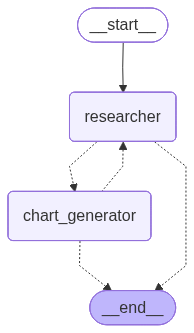

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='2bdb4a98-f71f-4774-8b5f-e10f11a12596'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run--678efcef-b7c2-4172-9e33-94b723ba352c-0', tool_calls=[{'name': 'llm_web_search', 'args': {'query': 'United Kingdom GDP 2019 2020 2021 2022 2023 current US$ World Bank data'}, 'id': 'call_3BkcJ6GcunbCJVSZ5vB1Mm4B', 'type': 'tool_call'}]), ToolMessage(content='United Kingdom GDP (current US$), World Bank (indicator: NY.GDP.MKTP.CD), rounded:\n\n- 2019: about $2.88 trillion\n- 2020: about $2.71 trillion\n- 2021: about $3.19 trillion\n- 2022: about $3.11 trillion\n- 2023: about $3.33 trillion\n\nNotes:\n- Values are in current US dollars (nominal) and subject to revision by the World Bank.\n- For exact figures and the latest updates, see the World Bank’s World Developmen

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='2bdb4a98-f71f-4774-8b5f-e10f11a12596'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run--678efcef-b7c2-4172-9e33-94b723ba352c-0', tool_calls=[{'name': 'llm_web_search', 'args': {'query': 'United Kingdom GDP 2019 2020 2021 2022 2023 current US$ World Bank data'}, 'id': 'call_3BkcJ6GcunbCJVSZ5vB1Mm4B', 'type': 'tool_call'}]), ToolMessage(content='United Kingdom GDP (current US$), World Bank (indicator: NY.GDP.MKTP.CD), rounded:\n\n- 2019: about $2.88 trillion\n- 2020: about $2.71 trillion\n- 2021: about $3.19 trillion\n- 2022: about $3.11 trillion\n- 2023: about $3.33 trillion\n\nNotes:\n- Values are in current US dollars (nominal) and subject to revision by the World Bank.\n- For exact figures and the latest updates, see the World Bank’s World Devel